# Malaria Deep Learning Model

# Import Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Loading Dataset

In [2]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
    split=['train'])

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Timothy Tandt\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection 

In [4]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(106, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset: tf.data.Dataset, TRAIN_RATIO: float, VAL_RATIO: float, TEST_RATIO: float):
    DATASET_SIZE = len(dataset)
    
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(TEST_RATIO*DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Dataset Visualization

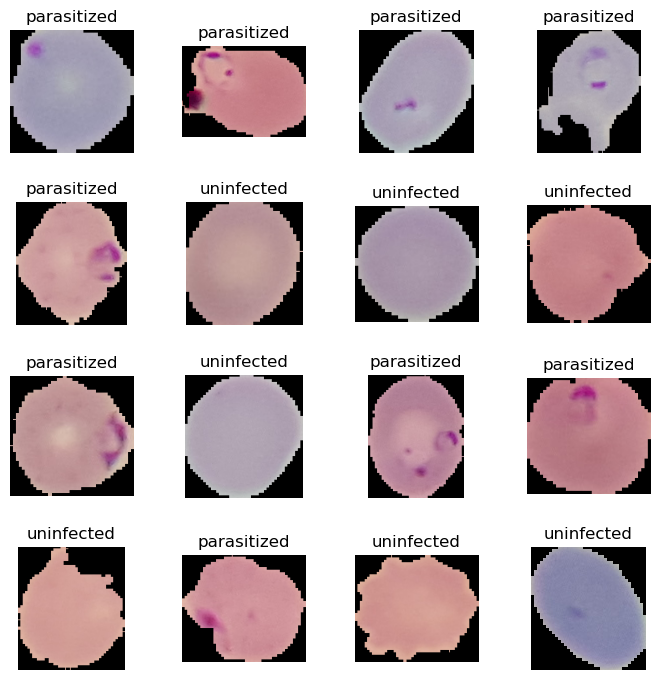

In [8]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# Iterate over the first 16 elements in the train_dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis("off")
    
# Show the plot
plt.show()

# Data Preprocessing

In [9]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [10]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [11]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
BATCH_SIZE = 32

In [13]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [14]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Model Creation

## Limit GPU Memory Usage

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [16]:
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [17]:
model = tf.keras.Sequential()

model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(100, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(10, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

In [19]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 0]

bce = BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1007609>

In [20]:
model.compile(optimizer=Adam(learning_rate=0.01), 
              loss=BinaryCrossentropy(),
              metrics="accuracy")

In [21]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 28s 31ms/step - loss: 0.3738 - accuracy: 0.8391 - val_loss: 0.7522 - val_accuracy: 0.8156
Epoch 2/20
689/689 [==============================] - 20s 29ms/step - loss: 0.2263 - accuracy: 0.9212 - val_loss: 1.5597 - val_accuracy: 0.5554
Epoch 3/20
689/689 [==============================] - 19s 28ms/step - loss: 0.2160 - accuracy: 0.9247 - val_loss: 0.1893 - val_accuracy: 0.9401
Epoch 4/20
689/689 [==============================] - 19s 28ms/step - loss: 0.1819 - accuracy: 0.9359 - val_loss: 0.2022 - val_accuracy: 0.9332
Epoch 5/20
689/689 [==============================] - 20s 29ms/step - loss: 0.1817 - accuracy: 0.9382 - val_loss: 0.3177 - val_accuracy: 0.9354
Epoch 6/20
689/689 [==============================] - 19s 28ms/step - loss: 0.1798 - accuracy: 0.9381 - val_loss: 0.2338 - val_accuracy: 0.9350
Epoch 7/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1513 - accuracy: 0.9502 - val_loss: 0.2817 - val_accuracy:

### 6. Plot out the performance

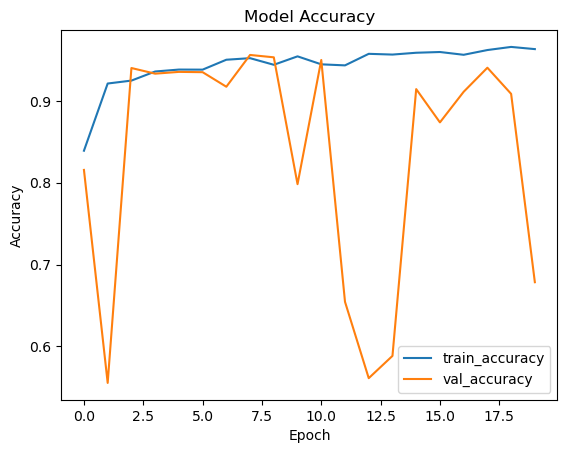

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [23]:
print(test_dataset, end='\n\n')
print(train_dataset)

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [24]:
test_dataset = test_dataset.batch(1)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [25]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 10s 3ms/step - loss: 1.8856 - accuracy: 0.6899


[1.8855900764465332, 0.6898803114891052]

In [26]:
model_prediction = model.predict(test_dataset.take(1))
model_prediction

array([[0.00837578]], dtype=float32)

In [27]:
result = model_prediction[0][0]
result

0.0083757825

In [28]:
def parasite_or_not(x):
    if (x < 0.5):
        return 'Parasatize'
    return 'Uninfected'

In [29]:
parasite_or_not(result)

'Parasatize'

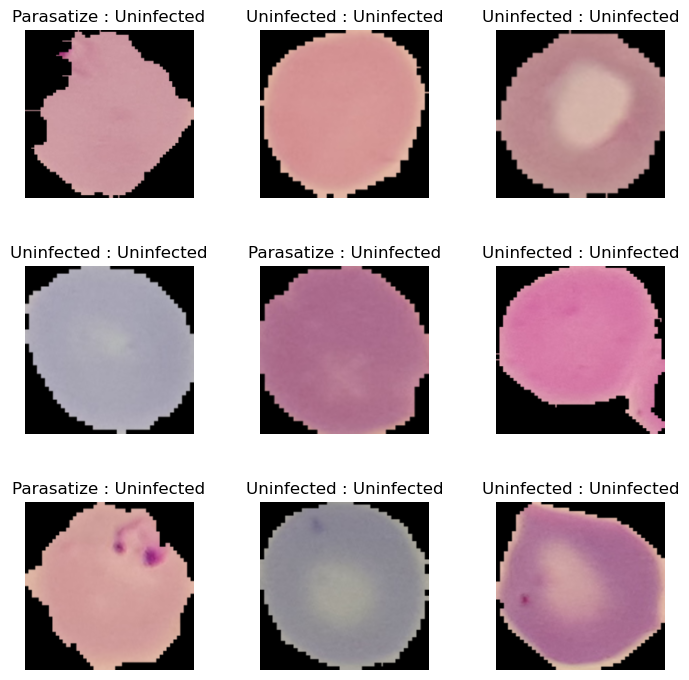

In [30]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

for i, (image, label) in enumerate(test_dataset.take(9)):
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    
    title = f"{parasite_or_not(label.numpy()[0])} : {parasite_or_not(model.predict(image)[0][0])}"
    plt.title(title)
    
    plt.axis("off")

# Loading and Saving

In [31]:
import os

In [32]:
current_directory = os.getcwd()
saved_path = os.path.join(current_directory, "model.h5")

In [33]:
model.save(saved_path)

In [34]:
loaded_model = tf.keras.models.load_model(saved_path)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Functional API

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [44]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

In [45]:
x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

In [53]:
lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_20 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_21 (Bat  (None, 109, 109, 16)     

In [54]:
lenet_model_func.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics="accuracy")

In [55]:
history = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5


689/689 [==============================] - 20s 28ms/step - loss: 0.3275 - accuracy: 0.8622 - val_loss: 0.9131 - val_accuracy: 0.8054
Epoch 2/5
689/689 [==============================] - 19s 28ms/step - loss: 0.1948 - accuracy: 0.9353 - val_loss: 0.2065 - val_accuracy: 0.9307
Epoch 3/5
689/689 [==============================] - 19s 27ms/step - loss: 0.1797 - accuracy: 0.9412 - val_loss: 0.4296 - val_accuracy: 0.9241
Epoch 4/5
689/689 [==============================] - 19s 27ms/step - loss: 0.1723 - accuracy: 0.9421 - val_loss: 0.2237 - val_accuracy: 0.9347
Epoch 5/5
689/689 [==============================] - 20s 29ms/step - loss: 0.1641 - accuracy: 0.9445 - val_loss: 0.2536 - val_accuracy: 0.9111


# Feature Extractor

In [56]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

In [57]:
x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)

x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

In [58]:
feature_extractor_model = Model(func_input, output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_24 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_25 (Bat  (None, 109, 109, 16

In [59]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

In [61]:
x = feature_extractor_model(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

In [63]:
lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 46656)             0         
                                                                 
 dense_20 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_28 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 10)                